In [1]:
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid 
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.model_selection import train_test_split
from PIL import Image


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
writer = SummaryWriter()

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
import json
import os
image_dir="data/train_mini/2021_train_mini"
json_file="data/train_mini/train_mini.json"
    
with open(json_file, 'r') as f:
    metadata = json.load(f)

# Extract images and annotations
image_metadata = metadata["images"]  # List of image metadata dicts
annotations = {ann["image_id"]: ann["category_id"] for ann in metadata["annotations"]}  # Map image_id to category_id
categories = {cat["id"]: cat["name"] for cat in metadata["categories"]}  # Map category_id to category name
# Create a mapping: {filename -> (latitude, longitude, category_id)}
image_data = {}
for img in image_metadata:
    #print(img["file_name"])
    #print(img["file_name"].split("/")[-2:])
    filename = img["file_name"].split("/")[-1]
    print(filename)
    image_id = img["id"]
    lat, long = img["latitude"], img["longitude"]
    category_id = annotations.get(image_id, -1)  # Default to -1 if not found
    image_data[filename] = (lat, long, category_id)
    break
# Get all valid image filenames that exist in metadata and directory
#self.image_files = [f for f in os.listdir(image_dir) if f in self.image_data]
image_files = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file in image_data:
            print(str(root + "/" + file).split("/")[-2:])
            print(str("/" + root + "/" + file).split("\\")[-1])
            image_files.append(str("/" + root + "/" + file).split("\\")[-1])
            break


d615f184-8af4-4c60-b9f8-3081c1607644.jpg
['2021_train_mini\\02912_Animalia_Chordata_Actinopterygii_Siluriformes_Ictaluridae_Ameiurus_nebulosus', 'd615f184-8af4-4c60-b9f8-3081c1607644.jpg']
02912_Animalia_Chordata_Actinopterygii_Siluriformes_Ictaluridae_Ameiurus_nebulosus/d615f184-8af4-4c60-b9f8-3081c1607644.jpg


In [ ]:
image_data[filename]

(43.83486, -71.22231, 2912)

In [ ]:
from torch.utils.data import Dataset
import json
import os


# need to normalise lat long data and add in the date data (month will do)

class ImageDatasetWithContext(Dataset):
    def __init__(self, image_dir, json_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Load metadata JSON
        with open(json_file, 'r') as f:
            metadata = json.load(f)

        # Extract images and annotations
        self.image_metadata = metadata["images"]  # List of image metadata dicts
        self.annotations = {ann["image_id"]: ann["category_id"] for ann in metadata["annotations"]}  # Map image_id to category_id
        self.categories = {cat["id"]: cat["name"] for cat in metadata["categories"]}  # Map category_id to category name
        # Create a mapping: {filename -> (latitude, longitude, category_id)}
        self.image_data = {}
        for img in self.image_metadata:
            filename = img["file_name"].split("/")[-1]
            image_id = img["id"]

            lat, long = img["latitude"], img["longitude"]
            if type(img["latitude"]) is not float or img["latitude"] > 180 or img["latitude"] < -180:
                lat = 0
            if type(img["longitude"]) is not float or img["longitude"] > 180 or img["longitude"] < -180:
                long = 0   

            # normalise to be in range 0 - 1
            lat = ((lat + 180) / 360) * 4.75 - 0.25
            long = ((long + 180) / 360) * 4.75 - 0.25

            
            category_id = self.annotations.get(image_id, -1)  # Default to -1 if not found
            self.image_data[filename] = (lat, long, category_id)
        # Get all valid image filenames that exist in metadata and directory
        #self.image_files = [f for f in os.listdir(image_dir) if f in self.image_data]
        self.image_files = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file in self.image_data:
                    self.image_files.append(str("/" + root + "/" + file).split("\\")[-1])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file_path= self.image_files[idx]
        file_name = file_path.split("/")[-1]
        image_path = os.path.join(self.image_dir, file_path)

        # Load and transform image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Retrieve lat/long and category
        lat, long, category_id = self.image_data[file_name]

        # Convert to tensors
        context_features = torch.tensor([lat, long], dtype=torch.float32)
        #category_label = torch.tensor(category_id, dtype=torch.long)

        return image, context_features, category_id

In [ ]:
train_data = ImageDatasetWithContext(image_dir="data/train_mini/2021_train_mini", json_file="data/train_mini/train_mini.json", transform=train_transform)
validation_data = ImageDatasetWithContext(image_dir="data/validation/2021_valid", json_file="data/validation/val.json", transform=val_transform)

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(validation_data, batch_size=128, shuffle=True, num_workers=0)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")

Training samples: 500000
Validation samples: 100000


In [ ]:
train_data[155550]

(tensor([[[-1.4500, -1.4500, -1.4500,  ...,  2.1290, -1.4500, -1.4500],
          [-1.4500, -1.4500, -1.4500,  ...,  2.1119, -1.4500, -1.4500],
          [ 2.1290,  2.1290,  2.1290,  ...,  2.1119, -1.4500, -1.4500],
          ...,
          [-1.4500, -1.4500,  2.0777,  ...,  2.0605,  2.0605,  2.0605],
          [-1.4500, -1.4500,  2.0777,  ..., -1.4500, -1.4500, -1.4500],
          [-1.4500, -1.4500,  2.0605,  ..., -1.4500, -1.4500, -1.4500]],
 
         [[-1.3529, -1.3529, -1.3529,  ...,  2.3410, -1.3529, -1.3529],
          [-1.3529, -1.3529, -1.3529,  ...,  2.3410, -1.3529, -1.3529],
          [ 2.3410,  2.3410,  2.3410,  ...,  2.3410, -1.3529, -1.3529],
          ...,
          [-1.3529, -1.3529,  2.3235,  ...,  2.3235,  2.3235,  2.3235],
          [-1.3529, -1.3529,  2.3235,  ..., -1.3529, -1.3529, -1.3529],
          [-1.3529, -1.3529,  2.3235,  ..., -1.3529, -1.3529, -1.3529]],
 
         [[-1.1247, -1.1247, -1.1247,  ...,  2.5529, -1.1247, -1.1247],
          [-1.1247, -1.1247,

In [ ]:
bird_indices = []
with open('bird_indices.txt', 'r') as f:
    for line in f:
        bird_indices.append(int(line[0:-1]))

bird_test_indices = []
with open('bird_val_indices.txt', 'r') as f:
    for line in f:
        bird_test_indices.append(int(line[0:-1]))

In [ ]:
# Find all indices where the target (label) corresponds to birds
# Create a subset dataset containing only birds
train_data_birds = Subset(train_data, bird_indices)

# label_index_map = {}
# index_list = [] 
# label_list = []

# for i, (_, _, label) in enumerate(train_data_birds):
#     index_list.append(i)
#     label_list.append(label)
# # now, for each label, randomly select 20% of indices, these will become the val set. 
# index_list_train, index_list_val, labels_train, labels_val = train_test_split(
# index_list, label_list, test_size=0.2, random_state=42, stratify=label_list)

In [ ]:
def output_list(list, file_name):
    with open(file_name, 'w') as f:
        for line in list:
            f.write(f"{line}\n")
    return

# output_list(index_list_train, "index_list_train.csv")
# output_list(index_list_val, "index_list_val.csv")
# output_list(labels_train, "labels_train.csv")
# output_list(labels_val, "labels_val.csv")

In [ ]:
def read_list_from_file(file_name):
    output_list = []
    with open(file_name, 'r') as f:
        for line in f:
            output_list.append(int(line[0:-1]))
    return output_list

index_list_train = read_list_from_file("index_list_train.csv") 
index_list_val = read_list_from_file("index_list_val.csv") 
labels_train = read_list_from_file("labels_train.csv") 
labels_val = read_list_from_file("labels_val.csv") 

In [ ]:
val_data_birds = Subset(train_data_birds, index_list_val)
train_data_birds = Subset(train_data_birds, index_list_train)

In [ ]:

# Create a DataLoader for the filtered dataset
train_loader_birds = DataLoader(train_data_birds, batch_size=32, shuffle=True, num_workers=0)
val_loader_birds = DataLoader(val_data_birds, batch_size=32, shuffle=True, num_workers=0)

# use validation set from problem as the unseen test set
test_data_birds = Subset(validation_data, bird_test_indices)
test_loader_birds = DataLoader(test_data_birds, batch_size=32, shuffle=True, num_workers=0)

print(f"Filtered train dataset contains {len(train_data_birds)} bird images.")
print(f"Filtered val dataset contains {len(val_data_birds)} bird images.")
print(f"Filtered test dataset contains {len(test_data_birds)} bird images.")

Filtered train dataset contains 59440 bird images.
Filtered val dataset contains 14860 bird images.
Filtered test dataset contains 14860 bird images.


In [ ]:
from collections import Counter
print(Counter(labels_val))
print(Counter(labels_train))

Counter({3405: 10, 3567: 10, 4445: 10, 3452: 10, 3833: 10, 3315: 10, 4544: 10, 3880: 10, 4570: 10, 3410: 10, 4507: 10, 3598: 10, 3368: 10, 4355: 10, 4335: 10, 3272: 10, 3187: 10, 4491: 10, 3167: 10, 3527: 10, 4524: 10, 3681: 10, 3985: 10, 3165: 10, 4543: 10, 3931: 10, 4033: 10, 3811: 10, 3231: 10, 4396: 10, 4414: 10, 4223: 10, 3983: 10, 4056: 10, 4002: 10, 4461: 10, 4486: 10, 4380: 10, 4273: 10, 3674: 10, 4106: 10, 3865: 10, 4064: 10, 4421: 10, 3543: 10, 3251: 10, 4537: 10, 4195: 10, 4116: 10, 4318: 10, 3353: 10, 4208: 10, 3288: 10, 4057: 10, 3252: 10, 4513: 10, 3901: 10, 3713: 10, 3517: 10, 3874: 10, 4203: 10, 3436: 10, 3854: 10, 3314: 10, 4376: 10, 3489: 10, 3596: 10, 4270: 10, 3184: 10, 3656: 10, 3463: 10, 3720: 10, 4410: 10, 3270: 10, 3648: 10, 3345: 10, 4381: 10, 3647: 10, 3785: 10, 4215: 10, 4029: 10, 4159: 10, 4542: 10, 4364: 10, 3141: 10, 4282: 10, 3180: 10, 4418: 10, 3261: 10, 4389: 10, 3711: 10, 3583: 10, 4392: 10, 3287: 10, 4466: 10, 3296: 10, 4436: 10, 3346: 10, 4071: 10, 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


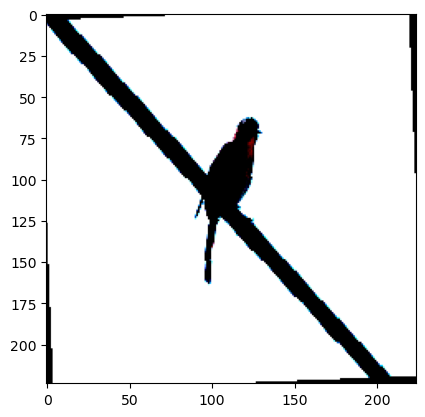

In [ ]:
plt.imshow(train_data_birds[98][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


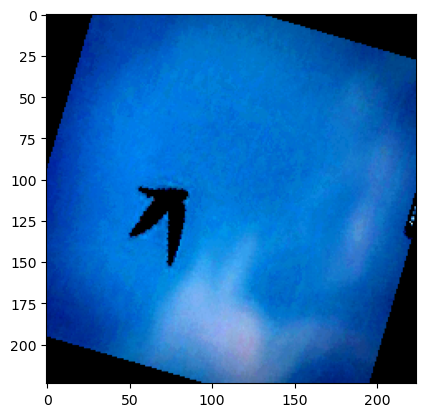

In [ ]:
plt.imshow(train_data_birds[4][0].permute(1,2,0))

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
#dataiter = iter(train_loader_birds)
#images, _, labels = next(dataiter)
#print(next(dataiter))
# show images
#imshow(make_grid(images))

In [ ]:
bird_cat_list = []

for file_name in train_data.image_files:
    full_species = file_name.split("/")[0]
    if "Animalia_Chordata_Aves" in full_species and full_species not in bird_cat_list:
        bird_cat_list.append(full_species)
n_classes = len(bird_cat_list)

In [ ]:
def remap_labels(labels):
    return (labels - 3111).long()  


def log_metrics_tensor_board(data_type, accuracy, top_5_accuracy, loss, epoch ):
    writer.add_scalar(f"Loss -  {data_type}", loss, epoch)
    writer.add_scalar(f"Accuracy -  {data_type}", 100 * accuracy, epoch)
    writer.add_scalar(f"Top 5 Accuracy - {data_type}", 100 * top_5_accuracy, epoch)
    return


def save_model(model, criterion, optimizer,  epoch, model_name):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"runs/model_pretrained_{model_name}.pth")
    return


def run_epoch(model, loader, criterion, optimizer=None, epoch=0, mode="train"):
    is_train = mode == "train"
    model.train() if is_train else model.eval()

    running_loss = 0.0
    correct = 0
    top_5_correct = 0
    total = 0

    with torch.set_grad_enabled(is_train):  # Only compute gradients during training
        for images, contextual_data, labels in loader: ##HERE
            images, contextual_data, labels = images.to(device), contextual_data.to(device), labels.to(device) ##HERE
            labels = remap_labels(labels).to(device)
            outputs = model(images, contextual_data)  # Forward pass  ##HERE
            loss = criterion(outputs, labels)  # Compute loss

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            # count total correct predicitions in batch
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # count total matches of label in top 5 class predictions 
            _, top_5_predicted = outputs.topk(5, dim=1)
            top_5_correct += torch.isin(labels, top_5_predicted).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    top_5_accuracy = top_5_correct / total
    log_metrics_tensor_board(mode, accuracy, top_5_accuracy, avg_loss, epoch)

    print(f"{mode.capitalize()} Accuracy: {100 * accuracy:.2f}%")
    print(f"Top 5 {mode.capitalize()} Accuracy: {100 * top_5_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - {mode.capitalize()} Loss: {avg_loss:.4f}")
    return avg_loss, accuracy


def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, epochs=5, early_stop_limit=5):
    best_val_loss = float('inf')
    early_stop_count = 0
    # lists to track of loss and accuracy metrics
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, epoch, mode="train")
        # if no val loader, evaluate stopping based on train metrics (e.g. when training on validation after training on train before evaluating on test)
        if val_loader is None:
            val_loss, val_acc = train_loss, train_acc
        else:
            val_loss, val_acc = run_epoch(model, val_loader, criterion, None, epoch, mode="validation")
        # store metrics
        train_loss_list.append(train_loss)
        train_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0
            # save best model so far
            save_model(model, criterion, optimizer,  epoch, model_name)
        else:
            early_stop_count += 1
        if early_stop_count == early_stop_limit:
            break
    eval_metrics = {
            "train_loss": train_loss_list,
            "val_loss": val_loss_list,
            "train_acc": train_acc_list,
            "val_acc": val_acc_list
        }
    return eval_metrics

In [ ]:
class EfficientNet_ContextualData(nn.Module):
    def __init__(self, num_classes, contextual_dim, tune_all_layers=True):
        super(EfficientNet_ContextualData, self).__init__()

        # Load EfficientNet-B0 with pretrained weights
        self.weights = EfficientNet_B0_Weights.DEFAULT
        self.pretrained_model = efficientnet_b0(weights=self.weights)

        # Remove classifier by keeping only the feature extractor cnn layers
        self.feature_extractor = self.pretrained_model.features

        # Freeze or unfreeze the training of cnn layers
        if not tune_all_layers:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        # get pretrained model number of output features
        cnn_out_features = self.pretrained_model.classifier[1].in_features
        
        # Define final classifier layer combining CNN + Contextual Data
        self.classifier = nn.Sequential(
            nn.Linear(cnn_out_features + contextual_dim, 2048),  # Combine features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, num_classes)  # Final output layer
        )

    def forward(self, image_data, contextual_data):

        # put image data through feature extactor 
        cnn_output = self.feature_extractor(image_data)
        cnn_output = torch.mean(cnn_output, dim=[2, 3])  # Global average pooling
        # flatten CNN output data
        cnn_output = cnn_output.view(cnn_output.size(0), -1)  

        # combine CNN output with contextual data
        combined_input = torch.cat((cnn_output, contextual_data), dim=1)
        # Pass through the classifier for final prediction
        output = self.classifier(combined_input)
        return output

In [ ]:
train_data_birds[900]

(tensor([[[-1.7240, -1.7240, -1.7240,  ..., -1.7240, -1.7240, -1.7240],
          [-1.7240, -1.7240, -1.7240,  ..., -1.7240, -1.7240, -1.7240],
          [-1.7240, -1.7240, -1.7240,  ..., -1.7240, -1.7240, -1.7240],
          ...,
          [-1.7240, -1.7240, -1.7240,  ..., -1.7240, -1.7240, -1.7240],
          [-1.7240, -1.7240, -1.7240,  ..., -1.7240, -1.7240, -1.7240],
          [-1.7240, -1.7240, -1.7240,  ..., -1.7240, -1.7240, -1.7240]],
 
         [[-1.6331, -1.6331, -1.6331,  ..., -1.6331, -1.6331, -1.6331],
          [-1.6331, -1.6331, -1.6331,  ..., -1.6331, -1.6331, -1.6331],
          [-1.6331, -1.6331, -1.6331,  ..., -1.6331, -1.6331, -1.6331],
          ...,
          [-1.6331, -1.6331, -1.6331,  ..., -1.6331, -1.6331, -1.6331],
          [-1.6331, -1.6331, -1.6331,  ..., -1.6331, -1.6331, -1.6331],
          [-1.6331, -1.6331, -1.6331,  ..., -1.6331, -1.6331, -1.6331]],
 
         [[-1.4036, -1.4036, -1.4036,  ..., -1.4036, -1.4036, -1.4036],
          [-1.4036, -1.4036,

In [ ]:
train_loader_birds

In [ ]:
for batch in train_loader_birds:
    print("Batch loaded successfully!")
    break

Batch loaded successfully!


In [ ]:
next(iter(train_loader_birds))

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

In [ ]:
# efficient net model 

model = EfficientNet_ContextualData(n_classes, 2)
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Train the model
eval_metrics = train_model(model, "efficientnet_contextual_data_b0", train_loader_birds, val_loader_birds, criterion, optimizer, epochs=100, early_stop_limit=3)

Min: -0.232880100607872, Max: 3.473243474960327
tensor([[-8.4205e-02, -1.3639e-01,  1.5345e-03,  ...,  3.3865e-03,
          5.9272e-01,  1.8804e-01],
        [-1.4228e-02, -3.4012e-02, -1.1755e-01,  ...,  3.7539e-01,
          5.5140e-01,  8.0209e-01],
        [-1.1331e-01,  1.9572e+00,  3.1282e-01,  ..., -2.2719e-02,
          4.1719e-01,  5.8621e-01],
        ...,
        [ 8.2321e-01,  8.4010e-02,  3.4660e-01,  ...,  7.4264e-01,
          4.0338e-01,  8.8472e-01],
        [ 1.0547e-01, -5.2386e-02,  6.3041e-01,  ...,  1.0076e-01,
          6.4064e-01,  4.9321e-01],
        [-8.4795e-02, -1.2131e-01,  6.4786e-01,  ...,  3.4156e-01,
          5.1168e-01,  2.9564e-01]], device='cuda:0', grad_fn=<CatBackward0>)
Min: -0.24361783266067505, Max: 3.9557952880859375
tensor([[ 0.0427,  0.0120, -0.0936,  ..., -0.1313,  0.5767,  0.7371],
        [-0.0404,  0.0048, -0.1538,  ...,  0.1269,  0.5646,  0.2044],
        [-0.1617, -0.0779, -0.0528,  ...,  0.2889,  0.5360,  0.7159],
        ...,
     

KeyboardInterrupt: 

In [ ]:
# Load the checkpoint
checkpoint = torch.load(f"runs/model_pretrained_efficientnet_b0.pth")

# turn to function def rebuild model
# Load the pretrained EfficientNet model
trained_model = efficientnet_b0(pretrained=False) 

trained_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(trained_model.classifier[1].in_features, n_classes)
)

for param in trained_model.parameters():
    param.requires_grad = True  # Enable fine tune training on all layers

trained_model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.001)  # Use the same optimizer as before
# Load model and optimizer states
trained_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_model(trained_model, "efficientnet_b0_final", val_loader_birds, None, criterion, optimizer, epochs=5, early_stop_limit=3)

In [ ]:
# evaluate on test
val_loss, val_acc = run_epoch(trained_model, test_loader_birds, criterion, None, epoch=0, mode="validation")

In [ ]:
save_model(trained_model, criterion, optimizer, epoch=18, model_name="efficientnet_b0_full_train")

In [ ]:
bird_classes = [cat for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]

In [ ]:
correct_pred

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in bird_classes}
total_pred = {classname: 0 for classname in bird_classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader_birds:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = remap_labels(labels).to(device)
        outputs = trained_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[bird_classes[label]] += 1
            total_pred[bird_classes[label]] += 1
# turn into dataframe and sort by smallest success classes
# then create confusion matrix for all classes - find the biggest misses


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in bird_classes}
total_pred = {classname: 0 for classname in bird_classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader_birds:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = remap_labels(labels).to(device)
        outputs = trained_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[bird_classes[label]] += 1
            total_pred[bird_classes[label]] += 1
# turn into dataframe and sort by smallest success classes
# then create confusion matrix for all classes - find the biggest misses


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')